<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Q-value-learning" data-toc-modified-id="Q-value-learning-1">Q value learning</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Comparing-environment-interfaces" data-toc-modified-id="Comparing-environment-interfaces-1.3">Comparing environment interfaces</a></span><ul class="toc-item"><li><span><a href="#Open-AI-Gym" data-toc-modified-id="Open-AI-Gym-1.3.1">Open AI Gym</a></span></li><li><span><a href="#Step" data-toc-modified-id="Step-1.3.2">Step</a></span></li><li><span><a href="#Decision" data-toc-modified-id="Decision-1.3.3">Decision</a></span></li></ul></li><li><span><a href="#Verifying-the-information-received-by-the-agent" data-toc-modified-id="Verifying-the-information-received-by-the-agent-1.4">Verifying the information received by the agent</a></span></li><li><span><a href="#Implementing-the-GameState" data-toc-modified-id="Implementing-the-GameState-1.5">Implementing the GameState</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.6">Summary</a></span></li></ul></li></ul></div>

# Q value learning

## Goal

On this notebook I will try to implement the first training of a model that uses Q value learning.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [9]:
import os
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor
import time

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position

%config Completer.use_jedi = False

In [8]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

## Comparing environment interfaces

### Open AI Gym

https://github.com/Kaggle/kaggle-environments#training

In [4]:
env = make('hungry_geese')
trainer = env.train([None, "greedy", "greedy", "greedy"])

In [11]:
obs = trainer.reset()
obs

{'remainingOverageTime': 60,
 'step': 0,
 'geese': [[17], [46], [0], [23]],
 'food': [51, 34],
 'index': 0}

In [13]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 1,
  'geese': [[6], [35], [1], [34, 23]],
  'food': [51, 25],
  'index': 0},
 201,
 False,
 {}]

In [14]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 2,
  'geese': [[72], [24], [2], [45, 34]],
  'food': [51, 25],
  'index': 0},
 100,
 False,
 {}]

In [15]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 3,
  'geese': [[61], [25, 24], [3], [46, 45]],
  'food': [51, 2],
  'index': 0},
 100,
 False,
 {}]

In [16]:
trainer.step('NORTH')

[{'remainingOverageTime': 60,
  'step': 4,
  'geese': [[50], [26, 25], [4], [35, 46]],
  'food': [51, 2],
  'index': 0},
 100,
 False,
 {}]

In [17]:
trainer.step('WEST')

[{'remainingOverageTime': 60,
  'step': 5,
  'geese': [[49], [27, 26], [5], [24, 35]],
  'food': [51, 2],
  'index': 0},
 100,
 False,
 {}]

In [18]:
trainer.step('EAST')

[{'remainingOverageTime': 60,
  'step': 6,
  'geese': [[], [28, 27], [71], [13, 24]],
  'food': [51, 2],
  'index': 0},
 0,
 True,
 {}]

So it seems we could use this implementation for training. The advantage is that we just have to care about our agent, not about the others.

In [19]:
env.configuration

{'episodeSteps': 200,
 'actTimeout': 1,
 'runTimeout': 1200,
 'columns': 11,
 'rows': 7,
 'hunger_rate': 40,
 'min_food': 2,
 'max_length': 99}

### Step

https://github.com/Kaggle/kaggle-environments#stepping

In [20]:
env = make('hungry_geese')

In [22]:
env.reset(num_agents=4)

[{'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 0,
   'geese': [[22], [73], [20], [65]],
   'food': [58, 37],
   'index': 0},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'ACTIVE'}]

In [23]:
env.state

[{'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 0,
   'geese': [[22], [73], [20], [65]],
   'food': [58, 37],
   'index': 0},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 0,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'ACTIVE'}]

I see a problem here, only the first state has information about the geese.

In [25]:
env.step(['NORTH', 'NORTH', 'NORTH', 'NORTH'])

[{'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 1,
   'geese': [[11], [62], [9], [54]],
   'food': [58, 37],
   'index': 0},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'ACTIVE'},
 {'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'ACTIVE'}]

So if we would want to use this approach we will have to manually copy information about, step, goose and food for the other players.

### Decision

I will be using Open AI gym interface since it is simpler.

## Verifying the information received by the agent

Let's create a very simple agent that prints the information so I can be sure of what the agent receives as input.

In [32]:
def print_agent(obs_dict, config_dict):
    print('observation', obs_dict)
    print('config', config_dict)
    return 'NORTH'

In [33]:
env = make('hungry_geese')

In [34]:
ret = env.run([print_agent, 'greedy'])

Does not print anything, so let's create a class to save that information.

In [37]:
class PrintAgent():
    def __init__(self):
        self.observations = []
        self.configurations = []
    
    def __call__(self, obs_dict, config_dict):
        self.observations.append(obs_dict)
        self.configurations.append(config_dict)
        return 'NORTH'

In [38]:
print_agent = PrintAgent()

In [39]:
ret = env.run([print_agent, 'greedy'])

In [40]:
len(ret)

81

In [41]:
print_agent.observations

[{'remainingOverageTime': 60,
  'step': 0,
  'geese': [[2], [25]],
  'food': [16, 58],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 1,
  'geese': [[68], [14]],
  'food': [16, 58],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 2,
  'geese': [[57], [15]],
  'food': [16, 58],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 3,
  'geese': [[46], [16, 15]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 4,
  'geese': [[35], [27, 16]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 5,
  'geese': [[24], [38, 27]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 6,
  'geese': [[13], [49, 38]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 7,
  'geese': [[2], [60, 49]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 8,
  'geese': [[68], [59, 60]],
  'food': [58, 67],
  'index': 0},
 {'remainingOverageTime': 60,
  'step': 9,
  'geese

In [42]:
ret[-1]

[{'action': 'NORTH',
  'reward': 8001,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 80,
   'geese': [[], [47]],
   'food': [67, 22],
   'index': 0},
  'status': 'DONE'},
 {'action': 'NORTH',
  'reward': 8101,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'DONE'}]

In [43]:
print_agent.configurations

[{'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
  'rows': 7,
  'hunger_rate': 40,
  'min_food': 2,
  'max_length': 99},
 {'episodeSteps': 200,
  'actTimeout': 1,
  'runTimeout': 1200,
  'columns': 11,
 

Everything seems fine. I have also seen that I can use a class as agent.

## Implementing the GameState

I'm going to implement the GameState on the library with nice tests, but I will also do some play here.

In [23]:
env = make('hungry_geese', configuration=dict(episodeSteps=20))
trainer = env.train([None, "greedy", "greedy", "greedy"])

configuration = env.configuration

obs = trainer.reset()

state = GameState()

state.update(obs, configuration)

done = False
while not done:
    action = 'NORTH'
    obs, reward, done, info = trainer.step(action)
    state.add_action(action)
    state.update(obs, configuration)

state.rewards

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [26]:
non_egocentric_state = GameState(egocentric_board=False)
for obs in state.history:
    non_egocentric_state.update(obs, configuration)

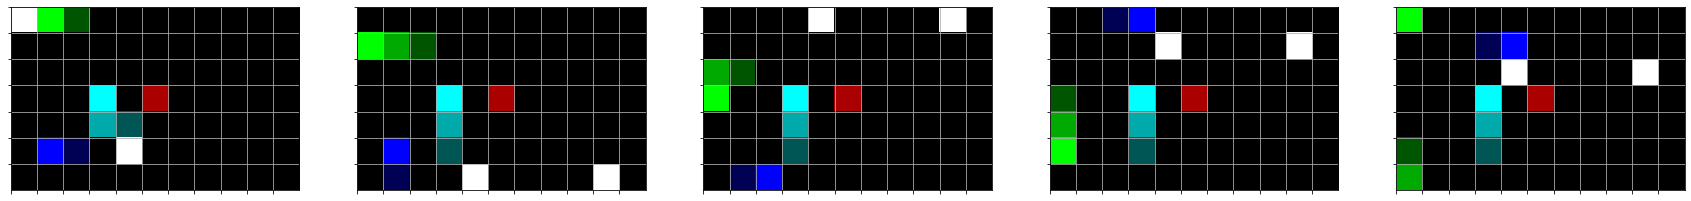

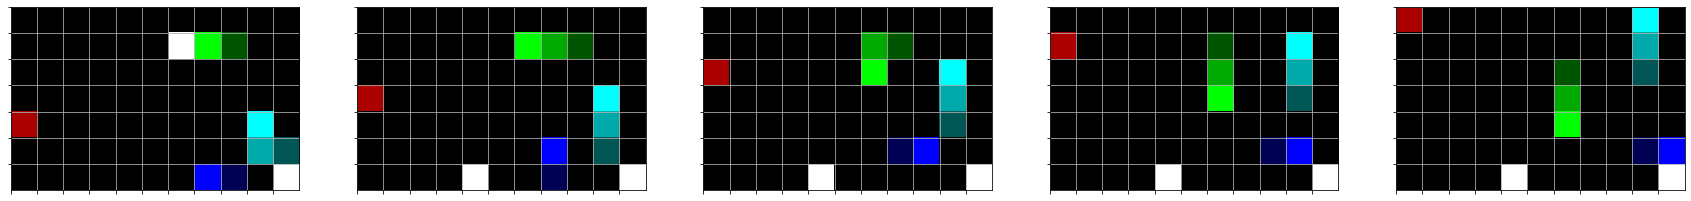

In [27]:
steps = list(range(15, 20))
for idx, step in enumerate(steps):
    plt.subplot(1, len(steps), idx+1)
    plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
    plt.imshow(state.render_board(state.boards[step]))
plt.show()
for idx, step in enumerate(steps):
    plt.subplot(1, len(steps), idx+1)
    plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
    plt.imshow(non_egocentric_state.render_board(non_egocentric_state.boards[step]))

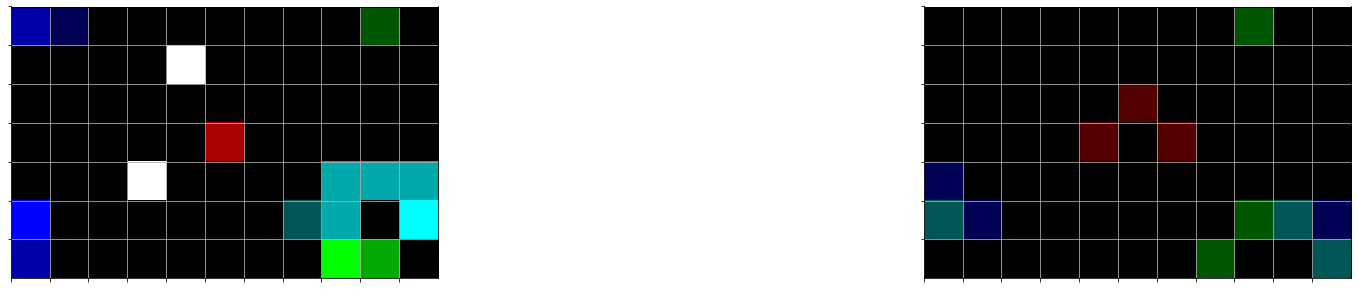

In [16]:
step = -2
plt.subplot(121); plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
plt.imshow(state.render_board(state.boards[step]))
plt.subplot(122); plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
plt.imshow(state.render_next_movements(state.boards[step]))

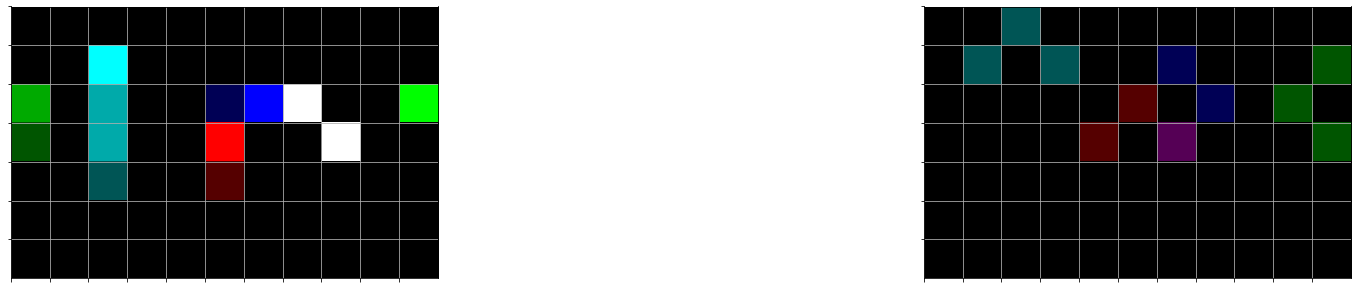

In [12]:
plt.subplot(121); plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
head_position = get_head_position(state.history[step]['geese'][state.history[step]['index']][0], state.configuration['columns'])
plt.imshow(make_board_egocentric(state.render_board(state.boards[step]), head_position))
plt.subplot(122); plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])
plt.imshow(make_board_egocentric(state.render_next_movements(state.boards[step]), head_position))

In [8]:
state.features

[array([ 5., 40., 40., 40., 40., 40.,  0.,  0.,  0.]),
 array([ 4., 39., 39., 39., 39., 39.,  0.,  0.,  0.]),
 array([ 3., 38., 38., 38., 38., 38.,  0.,  0.,  0.]),
 array([ 2., 37., 37., 37., 37., 37.,  0.,  0.,  0.]),
 array([ 1., 36., 36., 36., 36., 36.,  0.,  0.,  0.])]

In [12]:
state.history[-1]

{'remainingOverageTime': 60,
 'step': 9,
 'geese': [[13], [75, 64], [3, 14], []],
 'food': [56, 68],
 'index': 0}

In [11]:
len(state.history)

28

In [13]:
state.history[0]

{'remainingOverageTime': 60,
 'step': 0,
 'geese': [[64], [57], [67], [0]],
 'food': [22, 61],
 'index': 0}

In [12]:
state.configuration

{'episodeSteps': 200,
 'actTimeout': 1,
 'runTimeout': 1200,
 'columns': 11,
 'rows': 7,
 'hunger_rate': 40,
 'min_food': 2,
 'max_length': 99}

## Summary